In [10]:
import csv
import os
import subprocess
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt

In [11]:
# partial user list, acquired from /etc/passwd
home_list = subprocess.check_output(['ls', '/home']).decode('utf-8').strip().split('\n')
passwd_list = subprocess.check_output(['cat', '/etc/passwd']).decode('utf-8').strip().split('\n')
users_frame_palmetto = pd.DataFrame()

list_ = []
for entry in passwd_list:
    tmp_ = entry.split(':')
    if tmp_[0] in home_list:
        list_.append([tmp_[0],tmp_[4]])
        
users_frame_palmetto = pd.DataFrame(list_,columns=['userID','FullName'])

In [12]:
# full user list, from Marcin's records
# This does not work well because full name: i.e: Alex Feltus (publication) versus Alexander Feltus (users.csv) 
users_frame_file = pd.DataFrame()
userFile = 'palmetto_data/Users.csv'

list_ = []
with open(userFile, mode = 'r') as infile:
    reader = csv.reader(infile)
    next(reader, None)
    for row in reader:
        list_.append(row)

users_frame_file = pd.DataFrame(list_,columns=['LocalUserId', 'FullName', 'Rank', 'Title', 'Major', 'Department', 'College'])

In [13]:
# combine lists, from both /etc/passwd and Users.csv
userName = {}
for index, row in users_frame_palmetto.iterrows():
    try:
        fullName = row['FullName'].split(' ')
        fullName = [x.strip() for x in fullName]
        fullName = [x.lower() for x in fullName]
        lastName = fullName[len(fullName) - 1]
        if (lastName not in userName):
            userName[lastName] = {}
            userName[lastName]['0'] = fullName[:(len(fullName) - 1)]
        else:
            userName[lastName][str(len(userName[lastName]))] = fullName[:(len(fullName) - 1)]
    except AttributeError:
        continue
        
for index, row in users_frame_file.iterrows():
    try:
        fullName = row['FullName'].split(' ')
        fullName = [x.strip() for x in fullName]
        fullName = [x.lower() for x in fullName]
        lastName = fullName[len(fullName) - 1]
        if (lastName not in userName):
            userName[lastName] = {}
            userName[lastName]['0'] = fullName[:(len(fullName) - 1)]
        else:
            userName[lastName][str(len(userName[lastName]))] = fullName[:(len(fullName) - 1)]
    except AttributeError:
        continue
#print (userName)

In [16]:
allFiles = glob.glob('publications' + '/*.txt')
frame = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df = pd.read_table(file_,index_col=None, header=0, delimiter='\t')
    list_.append(df)
frame = pd.concat(list_)
print (frame.shape)

colnames = frame.columns.values.tolist()
print (colnames)

(16246, 56)
['\ufeffPT', 'AU', 'BA', 'CA', 'GP', 'RI', 'OI', 'BE', 'Z2', 'TI', 'X1', 'Y1', 'Z1', 'FT', 'PN', 'AE', 'Z3', 'SO', 'S1', 'SE', 'BS', 'VL', 'IS', 'SI', 'MA', 'BP', 'EP', 'AR', 'DI', 'D2', 'SU', 'PD', 'PY', 'AB', 'X4', 'Y4', 'Z4', 'AK', 'CT', 'CY', 'SP', 'CL', 'TC', 'Z8', 'ZR', 'ZB', 'ZS', 'Z9', 'U1', 'U2', 'SN', 'EI', 'BN', 'UT', 'PM', 'Unnamed: 55']


In [17]:
# check if any author has more than three phrases for full name in publication:
'''
for index, row in frame.iterrows():
    try:
        authors_list = row['AU'].split(';')
        for author in authors_list:
            publicationName = author.split(',')
            publicationName = [x.strip().lower for x in publicationName]
            if (len(publicationName) > 2):
                print (index, author)
    except AttributeError:
        continue
'''

"\nfor index, row in frame.iterrows():\n    try:\n        authors_list = row['AU'].split(';')\n        for author in authors_list:\n            publicationName = author.split(',')\n            publicationName = [x.strip().lower for x in publicationName]\n            if (len(publicationName) > 2):\n                print (index, author)\n    except AttributeError:\n        continue\n"

In [18]:
# Plot number of publications per year
years = list(set(frame['PY']))
years.sort()
print (years)

keyword_list = ['computation', 'compute', 'simulation', 'computational', 'simulate', 'genome',
               'sequence', 'sequencing', 'molecule', 'large scale', 'large-scale', 'massive', 
                'hpc', 'molecular', 'simulations', 'genomic']

keyword_counts = pd.Series(np.zeros(len(years)), index=years)

all_publications = pd.Series(np.zeros(len(years)), index=years)
one_publications = pd.Series(np.zeros(len(years)), index=years)
multi_publications = pd.Series(np.zeros(len(years)), index=years)

for index, row in frame.iterrows():
    authorCount = 0
    all_publications.loc[row['PY']] += 1.0
    try:
        authors_list = row['AU'].split(';')
        for author in authors_list:
            authorName = author.split(',')
            authorName = [x.strip().lower() for x in authorName]
            if (authorName[0] in userName):
                try:
                    authorFirstName = authorName[1].split(' ')
                except IndexError:
                    print ("Error: ", authorName)
                for key in userName[authorName[0]]:
                    if (authorFirstName[0] in userName[authorName[0]][key]):
                        #print (authorName, " = ", userName[authorName[0]][key], index)
                        authorCount += 1                      
    except AttributeError:
        continue
    if (authorCount > 0):
        one_publications.loc[row['PY']] += 1.0
        try:
            abstract_words = row['AB'].split(' ')
            abstract_words = [x.strip().lower() for x in abstract_words]
            for word in keyword_list:
                if word in abstract_words:
                    keyword_counts.loc[row['PY']] += 1.0
                    break
        except AttributeError:
            continue
    if (authorCount > 1):
        multi_publications.loc[row['PY']] += 1.0


[2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
Error:  ['ke']


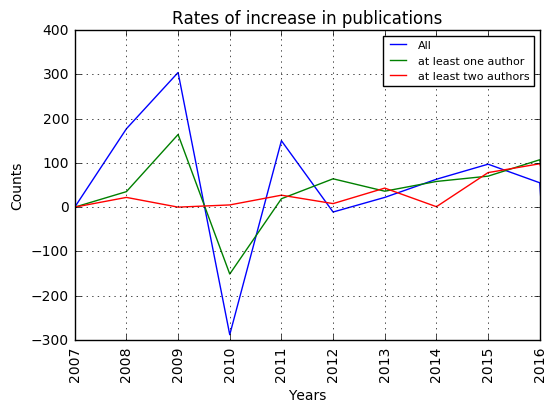

In [19]:
%matplotlib inline

all_growth = pd.Series(np.zeros(len(years)), index=years)
one_growth = pd.Series(np.zeros(len(years)), index=years)
multi_growth = pd.Series(np.zeros(len(years)), index=years)

for i in range(1, len(years)):
    all_growth.iloc[i] = all_publications.iloc[i] - all_publications.iloc[i-1]
    one_growth.iloc[i] = one_publications.iloc[i] - one_publications.iloc[i-1]
    multi_growth.iloc[i] = multi_publications.iloc[i] - multi_publications.iloc[i-1]
    
xlab = [str(x) for x in years]

plt.plot(all_growth)
plt.plot(one_growth)
plt.plot(multi_growth)
plt.xticks(years, xlab, rotation='vertical')
plt.xlabel('Years')
plt.ylabel('Counts')
plt.title('Rates of increase in publications')
plt.axis([2007, 2016, -300, 400])
plt.grid(True)
plt.legend(['All', 'at least one author', 'at least two authors'], loc='upper right', fontsize=8)
plt.show()

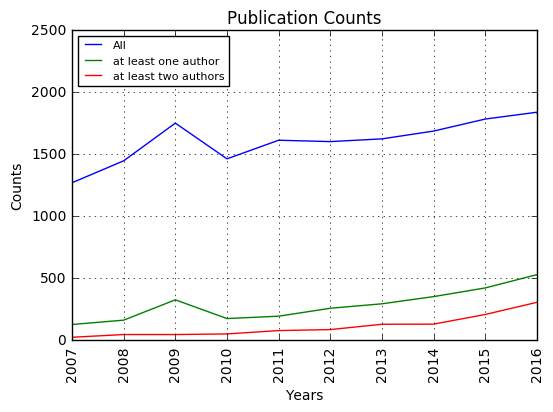

In [20]:
%matplotlib inline

xlab = [str(x) for x in years]

plt.plot(all_publications[0:11])
plt.plot(one_publications[0:11])
plt.plot(multi_publications[0:11])
plt.xticks(years, xlab, rotation='vertical')
plt.xlabel('Years')
plt.ylabel('Counts')
plt.title('Publication Counts')
plt.axis([2007, 2016, 0, 2500])
plt.grid(True)
plt.legend(['All', 'at least one author', 'at least two authors'], loc='upper left', fontsize=8)
plt.show()

In [21]:
print(all_publications)
print(one_publications)
print(multi_publications)
print(keyword_counts)

2007    1268.0
2008    1445.0
2009    1749.0
2010    1461.0
2011    1611.0
2012    1600.0
2013    1622.0
2014    1685.0
2015    1782.0
2016    1837.0
2017     186.0
dtype: float64
2007    125.0
2008    160.0
2009    324.0
2010    173.0
2011    192.0
2012    256.0
2013    292.0
2014    350.0
2015    420.0
2016    527.0
2017     47.0
dtype: float64
2007     22.0
2008     44.0
2009     44.0
2010     49.0
2011     76.0
2012     84.0
2013    127.0
2014    128.0
2015    206.0
2016    304.0
2017     30.0
dtype: float64
2007     25.0
2008     46.0
2009     47.0
2010     61.0
2011     66.0
2012     68.0
2013    102.0
2014     99.0
2015    152.0
2016    157.0
2017     14.0
dtype: float64


In [22]:
print (one_publications/all_publications)
print (multi_publications/all_publications)

2007    0.098580
2008    0.110727
2009    0.185249
2010    0.118412
2011    0.119181
2012    0.160000
2013    0.180025
2014    0.207715
2015    0.235690
2016    0.286881
2017    0.252688
dtype: float64
2007    0.017350
2008    0.030450
2009    0.025157
2010    0.033539
2011    0.047176
2012    0.052500
2013    0.078298
2014    0.075964
2015    0.115600
2016    0.165487
2017    0.161290
dtype: float64


In [ ]:
!cat /etc/passwd